In [1]:
import os

from fsspec.asyn import running_async
from sklearn.utils.validation import validate_data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt
from transformers import image_transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [9]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform = image_transforms)
len(dataset)

2300

In [5]:
class_nm = dataset.classes
class_nm

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [36]:
num_classes = len(dataset.classes)
num_classes

6

In [10]:
train_size = int(0.75*len(dataset))
val_size =  len(dataset) - train_size

train_size , val_size

(1725, 575)

In [11]:
from torch.utils.data import random_split

train_dataset , val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(train_dataset , batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = 32, shuffle = True)

In [13]:
for image,labels in train_loader:
    print(image.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [20]:
labels[3]

tensor(2)

In [15]:
image[1].shape

torch.Size([3, 224, 224])

In [16]:
image[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.2282355].


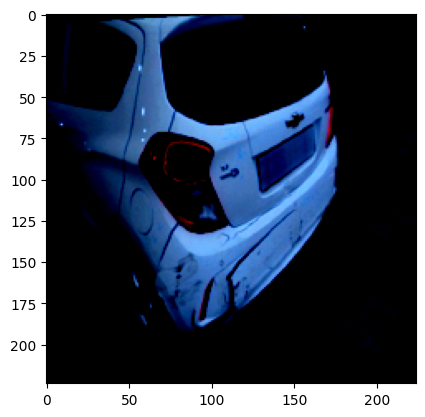

In [18]:
plt.imshow(image[1].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5179958].


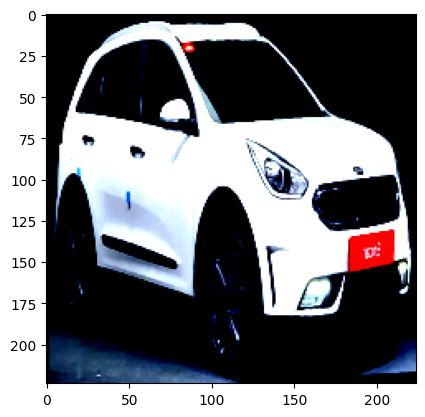

In [19]:
plt.imshow(image[3].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].


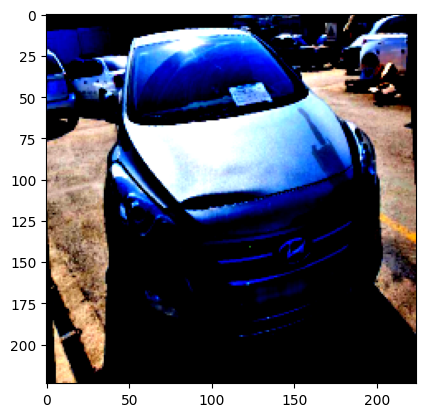

In [28]:
plt.imshow(image[20].permute(1,2,0))

## Model Training(CNN)

In [40]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride =1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride =1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride =1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [51]:
def train_model(model , criterion , optimizer , epochs = 5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images, labels) in enumerate(train_loader):
            images , labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs , labels)
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch : {batch_num+1} , Epoch : {epoch+1} , Loss : {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch : [{epoch+1}/{epochs}] , Avg_Loss : {epoch_loss:.4f}")

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images , labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy : {100 * correct /total:.2f}% ***")
    end = time.time()
    print(f"Execution time : {end-start} seconds")

    return all_labels,all_predictions


In [52]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

all_labels , all_prediction  = train_model(model , criterion , optimizer , epochs = 10)

Batch : 10 , Epoch : 1 , Loss : 1.77
Batch : 20 , Epoch : 1 , Loss : 1.75
Batch : 30 , Epoch : 1 , Loss : 1.76
Batch : 40 , Epoch : 1 , Loss : 1.54
Batch : 50 , Epoch : 1 , Loss : 1.65
Epoch : [1/10] , Avg_Loss : 2.1240
*** Validation Accuracy : 44.00% ***
Batch : 10 , Epoch : 2 , Loss : 1.38
Batch : 20 , Epoch : 2 , Loss : 1.32
Batch : 30 , Epoch : 2 , Loss : 1.43
Batch : 40 , Epoch : 2 , Loss : 1.28
Batch : 50 , Epoch : 2 , Loss : 1.37
Epoch : [2/10] , Avg_Loss : 1.2893
*** Validation Accuracy : 42.09% ***
Batch : 10 , Epoch : 3 , Loss : 1.18
Batch : 20 , Epoch : 3 , Loss : 0.97
Batch : 30 , Epoch : 3 , Loss : 1.10
Batch : 40 , Epoch : 3 , Loss : 1.13
Batch : 50 , Epoch : 3 , Loss : 1.10
Epoch : [3/10] , Avg_Loss : 1.1603
*** Validation Accuracy : 55.65% ***
Batch : 10 , Epoch : 4 , Loss : 0.93
Batch : 20 , Epoch : 4 , Loss : 1.20
Batch : 30 , Epoch : 4 , Loss : 1.10
Batch : 40 , Epoch : 4 , Loss : 1.24
Batch : 50 , Epoch : 4 , Loss : 0.92
Epoch : [4/10] , Avg_Loss : 1.0363
*** Valid

## Model 2 (CNN With Regularization)

In [53]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride =1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride =1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride =1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [55]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001,weight_decay=1e-4)

all_labels , all_prediction  = train_model(model , criterion , optimizer , epochs = 10)

Batch : 10 , Epoch : 1 , Loss : 9.15
Batch : 20 , Epoch : 1 , Loss : 5.91
Batch : 30 , Epoch : 1 , Loss : 1.93
Batch : 40 , Epoch : 1 , Loss : 1.54
Batch : 50 , Epoch : 1 , Loss : 1.58
Epoch : [1/10] , Avg_Loss : 6.4943
*** Validation Accuracy : 39.13% ***
Batch : 10 , Epoch : 2 , Loss : 1.43
Batch : 20 , Epoch : 2 , Loss : 1.15
Batch : 30 , Epoch : 2 , Loss : 1.27
Batch : 40 , Epoch : 2 , Loss : 1.49
Batch : 50 , Epoch : 2 , Loss : 1.16
Epoch : [2/10] , Avg_Loss : 1.3960
*** Validation Accuracy : 48.52% ***
Batch : 10 , Epoch : 3 , Loss : 1.32
Batch : 20 , Epoch : 3 , Loss : 1.03
Batch : 30 , Epoch : 3 , Loss : 1.02
Batch : 40 , Epoch : 3 , Loss : 1.21
Batch : 50 , Epoch : 3 , Loss : 1.34
Epoch : [3/10] , Avg_Loss : 1.2573
*** Validation Accuracy : 50.61% ***
Batch : 10 , Epoch : 4 , Loss : 1.25
Batch : 20 , Epoch : 4 , Loss : 1.29
Batch : 30 , Epoch : 4 , Loss : 1.50
Batch : 40 , Epoch : 4 , Loss : 1.53
Batch : 50 , Epoch : 4 , Loss : 1.18
Epoch : [4/10] , Avg_Loss : 1.2511
*** Valid

## Model 3 (Transfer Learning With EfficientNet)

In [56]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\mudit/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 11.8MB/s]


1280

In [57]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [58]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr = 0.001)

all_labels , all_prediction  = train_model(model , criterion , optimizer , epochs = 10)

Batch : 10 , Epoch : 1 , Loss : 1.75
Batch : 20 , Epoch : 1 , Loss : 1.46
Batch : 30 , Epoch : 1 , Loss : 1.43
Batch : 40 , Epoch : 1 , Loss : 1.27
Batch : 50 , Epoch : 1 , Loss : 1.24
Epoch : [1/10] , Avg_Loss : 1.4656
*** Validation Accuracy : 57.22% ***
Batch : 10 , Epoch : 2 , Loss : 1.15
Batch : 20 , Epoch : 2 , Loss : 1.10
Batch : 30 , Epoch : 2 , Loss : 1.21
Batch : 40 , Epoch : 2 , Loss : 1.11
Batch : 50 , Epoch : 2 , Loss : 0.97
Epoch : [2/10] , Avg_Loss : 1.1223
*** Validation Accuracy : 63.30% ***
Batch : 10 , Epoch : 3 , Loss : 1.06
Batch : 20 , Epoch : 3 , Loss : 0.98
Batch : 30 , Epoch : 3 , Loss : 0.92
Batch : 40 , Epoch : 3 , Loss : 0.95
Batch : 50 , Epoch : 3 , Loss : 1.22
Epoch : [3/10] , Avg_Loss : 1.0341
*** Validation Accuracy : 63.13% ***
Batch : 10 , Epoch : 4 , Loss : 1.22
Batch : 20 , Epoch : 4 , Loss : 1.03
Batch : 30 , Epoch : 4 , Loss : 1.10
Batch : 40 , Epoch : 4 , Loss : 0.91
Batch : 50 , Epoch : 4 , Loss : 1.02
Epoch : [4/10] , Avg_Loss : 0.9613
*** Valid

## Model 4 (Transfer Learning With ResNet)

In [61]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # freeze
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze
        for param in self.model.layer4.parameters():
            param.requires_grad  =True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [62]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr = 0.001)

all_labels , all_prediction  = train_model(model , criterion , optimizer , epochs = 10)

Batch : 10 , Epoch : 1 , Loss : 0.89
Batch : 20 , Epoch : 1 , Loss : 0.80
Batch : 30 , Epoch : 1 , Loss : 0.54
Batch : 40 , Epoch : 1 , Loss : 0.68
Batch : 50 , Epoch : 1 , Loss : 0.39
Epoch : [1/10] , Avg_Loss : 0.8954
*** Validation Accuracy : 72.00% ***
Batch : 10 , Epoch : 2 , Loss : 0.50
Batch : 20 , Epoch : 2 , Loss : 0.29
Batch : 30 , Epoch : 2 , Loss : 0.35
Batch : 40 , Epoch : 2 , Loss : 0.45
Batch : 50 , Epoch : 2 , Loss : 0.41
Epoch : [2/10] , Avg_Loss : 0.5028
*** Validation Accuracy : 78.43% ***
Batch : 10 , Epoch : 3 , Loss : 0.34
Batch : 20 , Epoch : 3 , Loss : 0.26
Batch : 30 , Epoch : 3 , Loss : 0.43
Batch : 40 , Epoch : 3 , Loss : 0.59
Batch : 50 , Epoch : 3 , Loss : 0.19
Epoch : [3/10] , Avg_Loss : 0.3494
*** Validation Accuracy : 81.22% ***
Batch : 10 , Epoch : 4 , Loss : 0.16
Batch : 20 , Epoch : 4 , Loss : 0.30
Batch : 30 , Epoch : 4 , Loss : 0.14
Batch : 40 , Epoch : 4 , Loss : 0.28
Batch : 50 , Epoch : 4 , Loss : 0.28
Epoch : [4/10] , Avg_Loss : 0.2592
*** Valid

In [64]:
model = CarClassifierResNet(num_classes=num_classes,dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad,model.parameters()),lr = 0.005)

all_labels , all_prediction  = train_model(model , criterion , optimizer , epochs = 10)

Batch : 10 , Epoch : 1 , Loss : 0.98
Batch : 20 , Epoch : 1 , Loss : 0.75
Batch : 30 , Epoch : 1 , Loss : 0.80
Batch : 40 , Epoch : 1 , Loss : 0.83
Batch : 50 , Epoch : 1 , Loss : 0.68
Epoch : [1/10] , Avg_Loss : 0.8585
*** Validation Accuracy : 63.48% ***
Batch : 10 , Epoch : 2 , Loss : 0.52
Batch : 20 , Epoch : 2 , Loss : 0.49
Batch : 30 , Epoch : 2 , Loss : 1.09
Batch : 40 , Epoch : 2 , Loss : 0.43
Batch : 50 , Epoch : 2 , Loss : 0.59
Epoch : [2/10] , Avg_Loss : 0.5270
*** Validation Accuracy : 64.70% ***
Batch : 10 , Epoch : 3 , Loss : 0.34
Batch : 20 , Epoch : 3 , Loss : 0.43
Batch : 30 , Epoch : 3 , Loss : 0.41
Batch : 40 , Epoch : 3 , Loss : 0.31
Batch : 50 , Epoch : 3 , Loss : 0.33
Epoch : [3/10] , Avg_Loss : 0.3672
*** Validation Accuracy : 81.22% ***
Batch : 10 , Epoch : 4 , Loss : 0.24
Batch : 20 , Epoch : 4 , Loss : 0.10
Batch : 30 , Epoch : 4 , Loss : 0.27
Batch : 40 , Epoch : 4 , Loss : 0.18
Batch : 50 , Epoch : 4 , Loss : 0.46
Epoch : [4/10] , Avg_Loss : 0.2662
*** Valid

In [67]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_prediction)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       128
           1       0.67      0.84      0.75       104
           2       0.90      0.81      0.85       123
           3       0.75      0.82      0.78        61
           4       0.76      0.76      0.76        79
           5       0.90      0.82      0.86        80

    accuracy                           0.81       575
   macro avg       0.81      0.81      0.81       575
weighted avg       0.82      0.81      0.81       575



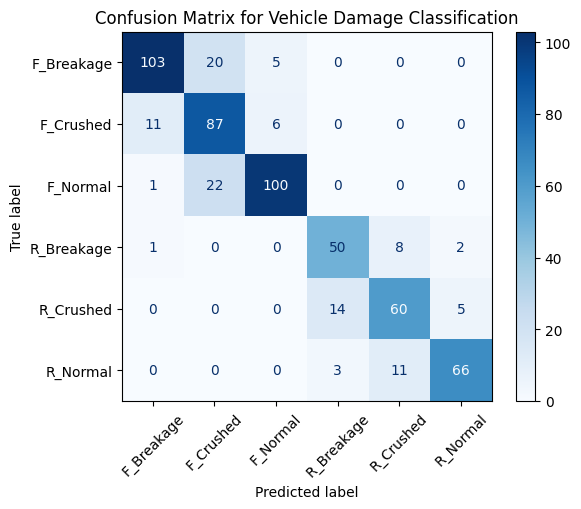

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_prediction, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_nm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [71]:
torch.save(model.state_dict(),'saved_model.pth')